In [1]:
import bempp.api
import numpy as np

Crear malla

In [18]:
grid = bempp.api.shapes.sphere(h=0.1)
#grid.plot()

In [19]:
grid.vertices.shape

(3, 1610)

In [20]:
grid.vertices

array([[ 1.        ,  0.        , -1.        , ...,  0.1547311 ,
         0.91767718,  0.058614  ],
       [ 0.        ,  1.        ,  0.        , ..., -0.22197253,
        -0.32872529, -0.05924478],
       [ 0.        ,  0.        ,  0.        , ..., -0.96270327,
        -0.22323286, -0.99652132]])

Definir espacios

Usar p1 en todos

In [21]:
dp0_space = bempp.api.function_space(grid, "DP", 0)
p1_space = bempp.api.function_space(grid, "P", 1)

Define potenciales (no es necesario)

In [22]:
identity = bempp.api.operators.boundary.sparse.identity(
    p1_space, p1_space, dp0_space)
dlp = bempp.api.operators.boundary.laplace.double_layer(
    p1_space, p1_space, dp0_space)
slp = bempp.api.operators.boundary.laplace.single_layer(
    dp0_space, p1_space, dp0_space)

Definir valor en la frontera 
Este valor será el entregado por la NN

In [23]:
@bempp.api.real_callable
def dirichlet_data(x, n, domain_index, result):
    result[0] = 1./(4 * np.pi * ((x[0]+0.9)**2 + x[1]**2 + x[2]**2)**(0.5))
    
dirichlet_fun = bempp.api.GridFunction(p1_space, fun=dirichlet_data)

Solver (no es necesario)

In [24]:
rhs = (.5 * identity + dlp) * dirichlet_fun 

c:\Users\achom\Desktop\Main\Code\Scientific-Computing\Physics-Neural-Networks\PINN\.venv\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:394: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


In [25]:
neumann_fun, info = bempp.api.linalg.cg(slp, rhs, tol=1E-4)

In [30]:
n_grid_points = 150
plot_grid = np.mgrid[-1:1:n_grid_points*1j, -1:1:n_grid_points*1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.zeros(plot_grid[0].size)))

In [31]:
points

array([[-1.        , -1.        , -1.        , ...,  1.        ,
         1.        ,  1.        ],
       [-1.        , -0.98657718, -0.97315436, ...,  0.97315436,
         0.98657718,  1.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

Se calcula función en puntos definidos

* NN entrega:
    + dirichlet_fun
    + neumann_fun   
.
* Points se define como uno quiera:
    - Entrenamiento: Borde
    - Estimación: Todo el dominio


Se utiliza el espacio de funciones??

slp_pot y dlp_pot se definen solo 1 vez!

pq se usa grid y nuevos puntos??

In [35]:
slp_pot = bempp.api.operators.potential.laplace.single_layer(
    dp0_space, points)
dlp_pot = bempp.api.operators.potential.laplace.double_layer(
    p1_space, points)
u_evaluated = slp_pot * neumann_fun - dlp_pot * dirichlet_fun

In [37]:
u_evaluated.shape

(1, 22500)

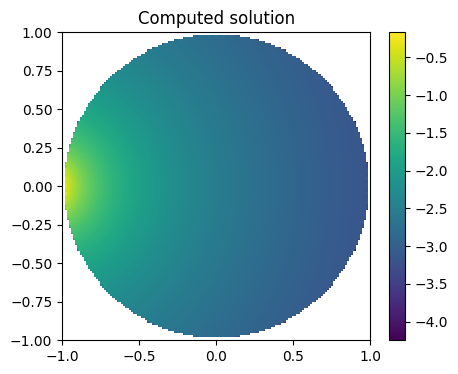

In [33]:
# The next command ensures that plots are shown within the IPython notebook
%matplotlib inline

# Filter out solution values that are associated with points outside the unit circle.
u_evaluated = u_evaluated.reshape((n_grid_points,n_grid_points))
radius = np.sqrt(plot_grid[0]**2 + plot_grid[1]**2)
u_evaluated[radius>1] = np.nan

# Plot the image
import matplotlib
matplotlib.rcParams['figure.figsize'] = (5.0, 4.0)

from matplotlib import pylab as plt

plt.imshow(np.log(np.abs(u_evaluated.T)), extent=(-1,1,-1,1))
plt.title('Computed solution')
plt.colorbar()

In [34]:
u_evaluated.shape

(150, 150)

In [17]:
print(u_evaluated)

[[       nan 0.34744121        nan]
 [0.028163   0.07966082 0.02813451]
 [       nan 0.019912          nan]]


In [77]:
grid.get_element(1)

In [39]:
help(dlp)

Help on BoundaryOperatorWithAssembler in module bempp.api.assembly.boundary_operator object:

class BoundaryOperatorWithAssembler(BoundaryOperator)
 |  BoundaryOperatorWithAssembler(domain, range_, dual_to_range, assembler, operator_descriptor, transpose=False)
 |  
 |  Implements a boundary operator together with an assembler.
 |  
 |  Method resolution order:
 |      BoundaryOperatorWithAssembler
 |      BoundaryOperator
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, domain, range_, dual_to_range, assembler, operator_descriptor, transpose=False)
 |      Initialize a boundary operator with assembler.
 |  
 |  ----------------------------------------------------------------------
 |  Readonly properties defined here:
 |  
 |  assembler
 |      Return the assembler associated with this operator.
 |  
 |  descriptor
 |      Operator descriptor.
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from Bounda

In [40]:
dirichlet_fun.coefficients

array([0.04189739, 0.059163  , 0.85988485, ..., 0.05506992, 0.0427759 ,
       0.0575023 ])